Fund managers report their holdings every month. They don’t want to tell investors they lost money on meme stocks. So at the end of the month, they [sell low-quality assets](https://www.investopedia.com/terms/w/windowdressing.asp) and buy high-quality assets, like bonds.

We might be able to take advantage of this by buying bonds at the end of the month and selling them at the beginning of the month.

Why does this work? The edge is probably too messy, too small, or just not interesting to professionals. Which makes it perfect for us.

Most people over-complicate algorithmic trading – it really can be this simple.

Here’s how to investigate this effect with Python, step by step:

# Evaluate A Real Trading Strategy With Python And Pandas


## Step 1: Get Data


We’re going to use TLT as a proxy for bonds. We’ll use the yFinance library to get 10 years of data in 1 line of code.

But first, the imports:

In [36]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series

from openbb_terminal.sdk import openbb

I’m using Jupyter Notebook and want to plot my charts inline which is what %matplotlib inline does.

Let’s get the data.

In [37]:
tlt: DataFrame = openbb.stocks.load("TLT", start_date="2002-01-01", end_date="2022-06-30")

Loading Daily data for TLT with starting period 2002-07-30.

This downloads 5,015 days of price history into a DataFrame.



## Step 2: Prepare Data

Let’s add a few columns to the DataFrame that we’ll use later.

First, we compute the log returns.

In [38]:
# compute log returns (so we can add together later - cannot do that with simple returns)
tlt["log_return"] = tlt['Adj Close'].apply(np.log).diff(1)
tlt.head()

,Open,High,Low,Close,Adj Close,Volume,log_return
date,,,,,,,
2002-07-30,81.750000,81.900002,81.519997,81.519997,41.236382,6100,NaN
2002-07-31,81.949997,82.800003,81.900002,82.529999,41.747307,29400,0.012314
2002-08-01,82.540001,83.019997,82.540001,83.000000,41.985058,25000,0.005679
2002-08-02,83.160004,84.099998,82.879997,83.849998,42.415043,52800,0.010189
2002-08-05,84.040001,84.440002,83.849998,84.220001,42.602200,61100,0.004403


Then we’ll add a column for the calendar day of the month (1 – 31) and a column for the year.



In [39]:
# add a column with the day of the month
tlt["day_of_month"] = tlt.index.day

In [40]:
# add a column with the year
tlt["year"] = tlt.index.year
tlt.head()

,Open,High,Low,Close,Adj Close,Volume,log_return,day_of_month,year
date,,,,,,,,,
2002-07-30,81.750000,81.900002,81.519997,81.519997,41.236382,6100,NaN,30,2002
2002-07-31,81.949997,82.800003,81.900002,82.529999,41.747307,29400,0.012314,31,2002
2002-08-01,82.540001,83.019997,82.540001,83.000000,41.985058,25000,0.005679,1,2002
2002-08-02,83.160004,84.099998,82.879997,83.849998,42.415043,52800,0.010189,2,2002
2002-08-05,84.040001,84.440002,83.849998,84.220001,42.602200,61100,0.004403,5,2002


## Step 3: Investigate Our Hypothesis


We expect there to be positive returns in TLT toward the end of the month. We expect this because we think fund managers buy TLT at the end of the month. We expect there to be negative returns in TLT toward the beginning of the month. This is when fund managers sell their high-quality assets and go back to buying meme stocks.

To see if this is true, we want the mean return on every day of the month.

In [41]:
# group by day number of the month
grouped_by_day = tlt.groupby("day_of_month").log_return.mean()
grouped_by_day.head()

day_of_month
1   -0.000567
2   -0.000642
3   -0.001381
4    0.000240
5   -0.002565
Name: log_return, dtype: float64

Then it’s simple to plot:



<AxesSubplot: title={'left': 'Mean Log Returns by Calendar Day of Month'}, xlabel='day_of_month'>

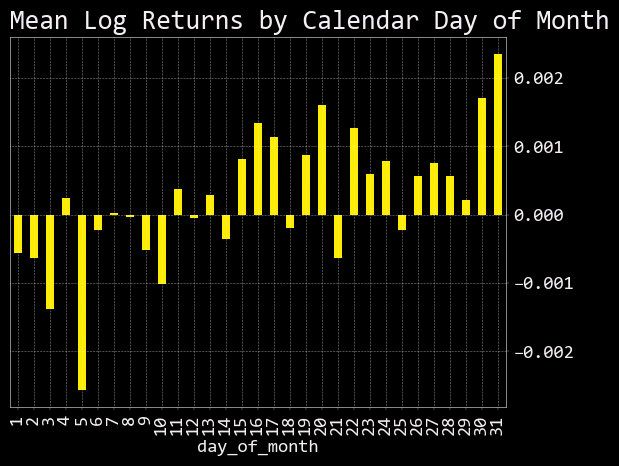

In [42]:
# plot the mean returns across the entire sample period
# we see evidence of the effect
grouped_by_day.plot.bar(title="Mean Log Returns by Calendar Day of Month")

We see evidence that returns are positive during the last days of the month and negative during the first.

This is for the entire range of data. Explore the persistence by grouping and averaging returns during different time frames.



## Step 4: Build A Simple Trading Strategy


Let’s build a naive strategy to test our hypothesis:

- Buy and hold TLT during the last week of the month
- Short and hold TLT during the first week of the month

Simple.

This code creates 3 new columns:

- <i>first_week_returns</i> – the daily log return if it’s between the 1st and 7th day of the month, otherwise 0
- <i>last_week_returns</i> – the daily log return if it’s on or after the 23rd day of the month, otherwise 0
- <i>last_week_less_first_week</i> – the difference between last_week_returns and first_week_returns

<i>last_week_less_first_week</i> represents the returns from our naive strategy. It’s basically saying “go long TLT the last week” and “go short TLT the first week”.



In [43]:
# simple trading strategy
# buy 7 days before the end of the month sell on first day of the month

In [44]:
# grab the returns within the first week for aggregation purposes
tlt["first_week_returns"] = 0.0
tlt.loc[tlt.day_of_month <= 7, "first_week_returns"] = tlt[
    tlt.day_of_month <= 7
].log_return

In [45]:
# grab the returns within the last week for aggregation purposes
tlt["last_week_returns"] = 0.0
tlt.loc[tlt.day_of_month >= 23, "last_week_returns"] = tlt[
    tlt.day_of_month >= 23
].log_return
tlt.head()

,Open,High,Low,Close,Adj Close,Volume,log_return,day_of_month,year,first_week_returns,last_week_returns
date,,,,,,,,,,,
2002-07-30,81.750000,81.900002,81.519997,81.519997,41.236382,6100,NaN,30,2002,0.000000,NaN
2002-07-31,81.949997,82.800003,81.900002,82.529999,41.747307,29400,0.012314,31,2002,0.000000,0.012314
2002-08-01,82.540001,83.019997,82.540001,83.000000,41.985058,25000,0.005679,1,2002,0.005679,0.000000
2002-08-02,83.160004,84.099998,82.879997,83.849998,42.415043,52800,0.010189,2,2002,0.010189,0.000000
2002-08-05,84.040001,84.440002,83.849998,84.220001,42.602200,61100,0.004403,5,2002,0.004403,0.000000


In [47]:
# simulate a simple strategy where we are short the first week and long the last week
tlt["last_week_less_first_week"] = tlt.last_week_returns - tlt.first_week_returns
tlt.head()

,Open,High,Low,Close,Adj Close,Volume,log_return,day_of_month,year,first_week_returns,last_week_returns,last_week_less_first_week
date,,,,,,,,,,,,
2002-07-30,81.750000,81.900002,81.519997,81.519997,41.236382,6100,NaN,30,2002,0.000000,NaN,NaN
2002-07-31,81.949997,82.800003,81.900002,82.529999,41.747307,29400,0.012314,31,2002,0.000000,0.012314,0.012314
2002-08-01,82.540001,83.019997,82.540001,83.000000,41.985058,25000,0.005679,1,2002,0.005679,0.000000,-0.005679
2002-08-02,83.160004,84.099998,82.879997,83.849998,42.415043,52800,0.010189,2,2002,0.010189,0.000000,-0.010189
2002-08-05,84.040001,84.440002,83.849998,84.220001,42.602200,61100,0.004403,5,2002,0.004403,0.000000,-0.004403


## Step 5: Plot Returns


Let’s create a naive backtest of our naive strategy to get a feel for the returns.

<i>The point of this is not to have a highly accurate, statistically significant backtest. It’s to spend the shortest amount of time possible to see if this strategy is worth pursuing in more detail.</i>

First, we’ll sum up the returns by year and plot them.

We see more evidence that this effect is persistent through time. Since 2002, there have only been 3 years where returns are negative.

<AxesSubplot:title={'left':'Mean Log Strategy Returns by Year'}, xlabel='year'>

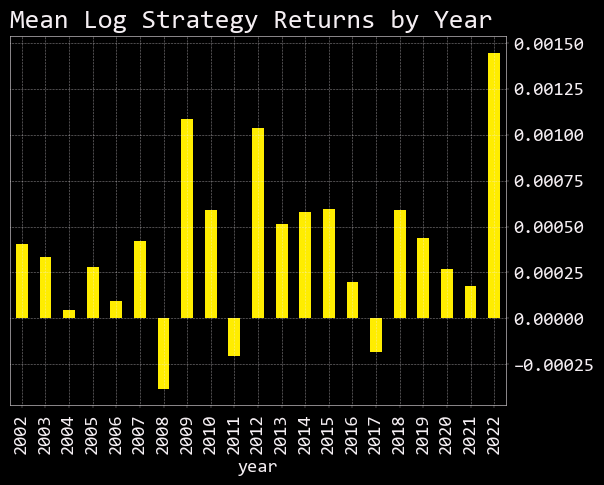

In [13]:
# group and mean the returns each year

(
    tlt.groupby("year")
    .last_week_less_first_week.mean()
    .plot.bar(title="Mean Log Strategy Returns by Year")
)

Let’s take a look at the cumulative returns by year.



<AxesSubplot: title={'left': 'Cumulative Sum of Returns By Year'}, xlabel='year'>

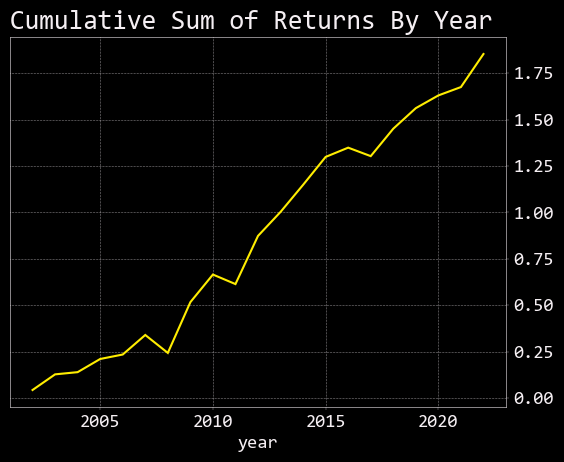

In [34]:
(
    tlt.groupby("year")
    .last_week_less_first_week.sum()
    .cumsum()
    .plot(title="Cumulative Sum of Returns By Year")
)

And we can do the same by day.



<AxesSubplot:title={'left':'Cumulative Sum of Returns By Day'}, xlabel='date'>

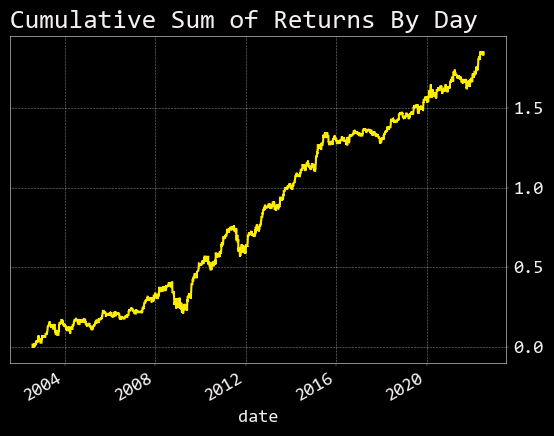

In [15]:
tlt.last_week_less_first_week.cumsum().plot(title="Cumulative Sum of Returns By Day")

There’s evidence that this effect is profitable. It’s worth spending more time exploring it more deeply.